## Mounting Google Drive


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


##Loading VGG16 model

In [5]:
from keras.applications import VGG16
conv_base = VGG16(weights= 'imagenet', include_top= False, input_shape= (150, 150, 3))

Using TensorFlow backend.


58892288/58889256 [==============================] - 1s 0us/step


##Architecture of VGG16

In [6]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

##Building the model

In [0]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation= 'relu'))
model.add(layers.Dense(256, activation= 'relu'))
model.add(layers.Dense(5, activation='softmax'))

##Data Preprocessing for Training and Testing

In [8]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
import os
import numpy as np

base_dir = r'gdrive/My Drive/face_shape_one'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

rescale_factor = 1./255

train_datagen = ImageDataGenerator(rescale= rescale_factor,
                                  width_shift_range= 40,
                                  height_shift_range= 0.2,
                                  shear_range= 0.2,
                                  zoom_range= 0.2,
                                  horizontal_flip= True,
                                  fill_mode= 'nearest')

test_datagen = ImageDataGenerator(rescale= rescale_factor)

target_width = 150
target_height = 150

train_sample_size = 400
train_batch_size = 20

valid_sample_size = 50
valid_batch_size = 10

test_sample_size = 50
test_batch_size = 10

train_generator = train_datagen.flow_from_directory(
                                directory= train_dir, 
                                target_size= (target_width, target_height),
                                batch_size= train_batch_size, 
                                class_mode= 'categorical')


validation_generator = test_datagen.flow_from_directory(
                                directory= validation_dir, 
                                target_size= (target_width, target_height), 
                                batch_size= valid_batch_size,
                                class_mode= 'categorical')

test_generator = test_datagen.flow_from_directory(
                                directory= test_dir, 
                                target_size= (target_width, target_height), 
                                batch_size= test_batch_size,
                                class_mode= 'categorical')


Found 400 images belonging to 5 classes.
Found 50 images belonging to 5 classes.
Found 50 images belonging to 5 classes.


##Freeze Conv Base before training


In [0]:
conv_base.trainable = False

##Compile the learning environment

In [0]:
model.compile(loss= 'categorical_crossentropy', 
              optimizer= optimizers.RMSprop(learning_rate=2e-5),
              metrics= ['acc'])

##Training end-to-end on Frozen layers

In [11]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
                    generator= train_generator,
                    steps_per_epoch= STEP_SIZE_TRAIN, 
                    epochs= 30, 
                    validation_data= validation_generator, 
                    validation_steps= STEP_SIZE_VALID)

Epoch 1/30
20/20 [==============================] - 118s 6s/step - loss: 1.6042 - acc: 0.2775 - val_loss: 1.6004 - val_acc: 0.2800
Epoch 2/30
20/20 [==============================] - 101s 5s/step - loss: 1.5360 - acc: 0.3075 - val_loss: 1.3286 - val_acc: 0.3200
Epoch 3/30
20/20 [==============================] - 101s 5s/step - loss: 1.4747 - acc: 0.3650 - val_loss: 1.5543 - val_acc: 0.3000
Epoch 4/30
20/20 [==============================] - 101s 5s/step - loss: 1.4418 - acc: 0.3775 - val_loss: 1.4563 - val_acc: 0.4400
Epoch 5/30
20/20 [==============================] - 101s 5s/step - loss: 1.4104 - acc: 0.4350 - val_loss: 1.2318 - val_acc: 0.4600
Epoch 6/30
20/20 [==============================] - 101s 5s/step - loss: 1.3984 - acc: 0.4300 - val_loss: 1.1486 - val_acc: 0.4600
Epoch 7/30
20/20 [==============================] - 101s 5s/step - loss: 1.3522 - acc: 0.4825 - val_loss: 1.0599 - val_acc: 0.4600
Epoch 8/30
20/20 [==============================] - 101s 5s/step - loss: 1.3144 - a

**Plotting the result**

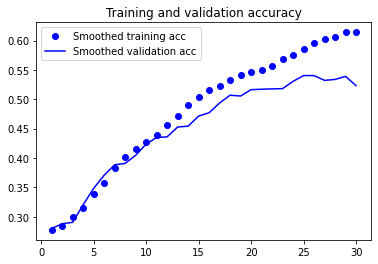

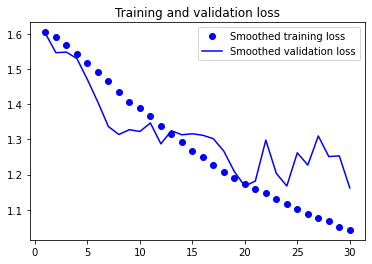

In [12]:
import matplotlib.pyplot as plt

# Plotting the results with smooth curve
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
       
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
           
        else:
            smoothed_points.append(point)
    return smoothed_points

def plot_result(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc)+1)
  plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed training acc')
  plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed training loss')
  plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed validation loss')
  plt.title('Training and validation loss') 
  plt.legend()
  plt.show()

plot_result(history)

#Fine-Tuning the model 
## Freeze all layers except the last four


In [0]:
conv_base.trainable = True

set_trainable = False

for layer in conv_base.layers:
  if layer.name == 'block5_conv1':
    set_trainable = True

  if set_trainable:
    layer.trainable = True

  else:
    layer.trainable = False

##Recompile the model

In [0]:
model.compile(loss= 'categorical_crossentropy', 
              optimizer= optimizers.RMSprop(learning_rate=1e-5),
              metrics= ['acc'])

##Retrain the model

In [24]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n//validation_generator.batch_size

history = model.fit_generator(
                    generator= train_generator,
                    steps_per_epoch= STEP_SIZE_TRAIN, 
                    epochs= 30, 
                    validation_data= validation_generator, 
                    validation_steps= STEP_SIZE_VALID)

Epoch 1/30
20/20 [==============================] - 120s 6s/step - loss: 0.9069 - acc: 0.6500 - val_loss: 0.8625 - val_acc: 0.5600
Epoch 2/30
20/20 [==============================] - 118s 6s/step - loss: 0.8394 - acc: 0.6825 - val_loss: 0.8751 - val_acc: 0.5400
Epoch 3/30
20/20 [==============================] - 118s 6s/step - loss: 0.7511 - acc: 0.7225 - val_loss: 1.1992 - val_acc: 0.4800
Epoch 4/30
20/20 [==============================] - 118s 6s/step - loss: 0.7974 - acc: 0.7325 - val_loss: 0.9742 - val_acc: 0.6000
Epoch 5/30
20/20 [==============================] - 118s 6s/step - loss: 0.7255 - acc: 0.7450 - val_loss: 1.3148 - val_acc: 0.5800
Epoch 6/30
20/20 [==============================] - 118s 6s/step - loss: 0.6812 - acc: 0.7550 - val_loss: 2.0461 - val_acc: 0.5200
Epoch 7/30
20/20 [==============================] - 118s 6s/step - loss: 0.6520 - acc: 0.7775 - val_loss: 1.6117 - val_acc: 0.6000
Epoch 8/30
20/20 [==============================] - 118s 6s/step - loss: 0.7050 - a

##Plotting the results

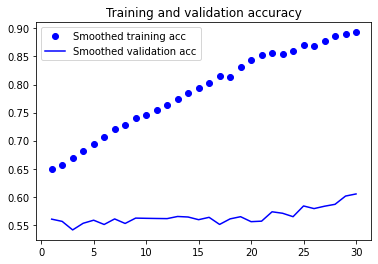

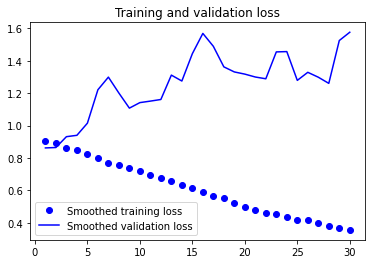

In [25]:
plot_result(history)

**Evaluating the model on test dataset**

In [0]:
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

test_loss, test_acc = model.evaluate_generator(test_generator, STEP_SIZE_TEST)


In [20]:
print('Accuracy on the dataset: ', test_acc*100, '%')

Accuracy on the dataset:  43.99999976158142 %


In [0]:
model.save('my_model.h5')